ここで、量子線形システム問題にまつわる少し発展的な話題を紹介する。これらのコラムの内容は本編の理解に必須ではないので、難しくて分からない場合は適宜飛ばして次に進んでほしい。

## コラム: 低ランク行列に対する高速な特異値分解とサンプリング

In [2]:
import sys
import time
from collections import Counter

import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt

print("python: %s"%sys.version)
print("numpy: %s"%np.version.version)
print("matplotlib: %s"%matplotlib.__version__)
print("scikit-learn: %s"%sklearn.__version__)


python: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
numpy: 1.14.3
matplotlib: 2.2.2
scikit-learn: 0.19.1


## 概要
低ランクなハミルトニアンは量子計算機で効率的にシミュレートすることができる。
ハミルトニアンの効率的なシミュレートは位相推定やHHLを行うための前提条件である。従って、低ランクな行列に対して量子計算機は種々の高速なアルゴリズムを自然に適用できる。
量子推薦システム(Quantum recommendation system)はそのような応用の一つで、量子計算機は低ランクな行列の任意の行ベクトルに対し、Top-$k$特異値空間へ射影したベクトルからのL2サンプリングを行えるというものである。このサンプリング操作はWebサービスにおいて行をユーザ、列をアイテム、要素を指定ユーザが指定アイテムを好きかどうか、という嗜好行列を考えると、購買履歴に基づくユーザへのアイテム推薦の操作に対応しており、かつ嗜好行列が低ランクであることを自然に仮定できる。従って、量子計算機は高速な推薦システムとして活用することができる。

しかし、一般に問題に低ランク近似可能性などの強い近似が加わった場合、通常の計算機での計算も高速になる点に注意しなければならない。近年、上記の量子推薦システムが行う操作は通常の計算機でも種々のデータ構造やアルゴリズムを用いることで多項式時間での実現が可能だということがわかっている。
この章では、低ランクな行列に対する打ち切り特異値分解、および特異値空間に射影されたベクトルからのサンプリングが、通常の計算機だけでも行列のサイズに対して指数的に高速になるという点について解説する。

この一連の研究は主にEwin Tangによって行われたものである。
この研究は以下の個別の主要要素をつなげたものである。

1. セグメント木
2. 確率的操作を用いた打ち切り特異値分解
3. 棄却サンプリング
4. 内積の推定

まず、問題設定を提示し、そののち上記の三つについてそれぞれ解説し、これを組みあわせて低ランク近似した特徴量からのサンプリングが可能であることをコードを実行しながら概観する。

## 問題設定

低ランク近似からの特異値空間の射影サンプリングは以下のような問題として定義される。

初期状態として、$2^n, 2^m$の大きさの行列$A$を考える。行列$A$は全ての要素が0である。
この時、以下の二つの操作がランダムな順序で$q$個要求される。

1. 値の更新
$A$の$i$行$j$列の要素を$v$に更新する。

2. 射影サンプリング
$A$の$i$行目の成分を$A$のtop-$k$特異値空間に射影したベクトル$v$を得る。
ベクトル$v$の$j$番目の要素を$\frac{v_j^2}{\sum_k v_l^2}$の確率で出力する。
ただし、$k$は高々$O(n,m)$である。

上記に$\epsilon$の誤差を許容した時、高速に処理を行いたい。
自明な上記のアルゴリズムは$2^n, 2^m$の配列をスパース形式で確保し、挿入を$O(n,m)$で行い、射影サンプリングは特異値分解を通して${\rm poly}(2^n,2^m)$で行う方法である。
これを改善し、${\rm poly}(q,n,m,\epsilon^{-1})$の計算量で行いたい。

量子計算機を用いると、上記の計算を${\rm poly}(q,n,m,\epsilon^{-1})$で行うことができる。
これは、HHLアルゴリズムの一部を変更し、Quantum projectionというプロトコルを実施することで可能となる。
近年のEwin Tangによる論文は、この計算が同じく${\rm poly}(q,n,m,\epsilon^{-1})$で可能であるというものである。


## 和のセグメント木

通常、我々がプログラムで配列を確保すると、メモリ上の連続的なアドレスに指定した容量の数列が確保される。
ランダムアクセスメモリでは読み出しと書き込みはO(1)で完了できるため、通常はこの方法で確保される。
一方、配列に対する要求が読み出しと書き込みだけではなく挿入や削除、サンプリングなどがある場合、
こうしたデータの保持の仕方は必ずしも高速とは限らない。
従って、データに対する要求が単なる読み出しと書き込みに限らない場合、その目的に適した特殊なデータの保持方法が用いられる。これをデータ構造をと呼ぶ。
和に関するセグメント木はデータ構造の一種であり、データの更新、区間和の計算やサンプリングを高速に行うことができる。

対象となるデータの大きさを$N=2^n$とする。２の累乗でない場合は、累乗になるまで末尾を0で埋める。、
まず、$2N$の長さの配列を確保する。最初は$2N$個の要素は0で埋まっている。
和のセグメント木では以下の4つの操作を行える。

1. 値の更新: i番目のデータに値vを書き込む。

2. 値の取得: i番目のデータを取り出す。

3. 総和の取得: 全データの和を取り出す。

4. サンプリング: $i$番目のデータを$\frac{a_i}{\sum_j a_j}$の確率で取り出す。

上記を通常の配列で愚直に行うと以下のようなコードになる。

In [3]:
class VectorSampler():
    def __init__(self,size):
        self.size = size
        self.array = np.zeros(size)
        self.sum = 0
        self.index_list = np.arange(self.size)
        
    def update(self,index,value):
        self.sum += value - self.array[index]
        self.array[index] = value
        
    def get_element(self,index):
        return self.array[index]
    
    def get_sum(self):
        return self.sum
    
    def sampling(self):
        normalized_array = self.array / self.sum
        result = np.random.choice(self.index_list, p = normalized_array)
        return result

上記の関数をベンチマークしてみよう。

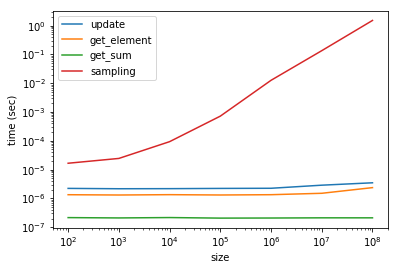

In [12]:
n_list_vec = [10**2,10**3,10**4,10**5,10**6,10**7,10**8]
update_time_vec = []
get_element_time_vec = []
get_sum_time_vec = []
sampling_time_vec = []
for n in n_list_vec:
    data_structure = VectorSampler(n)
    
    start_time = time.time()
    rep = 0
    while time.time()-start_time<0.1:
        index = np.random.randint(n)
        value = np.random.rand()
        data_structure.update(index,value)
        rep+=1
    elapsed = (time.time()-start_time)/rep
    update_time_vec.append(elapsed)
    
    start_time = time.time()
    rep = 0
    while time.time()-start_time<0.1:
        index = np.random.randint(n)
        data_structure.get_element(index)
        rep+=1
    elapsed = (time.time()-start_time)/rep
    get_element_time_vec.append(elapsed)
    
    start_time = time.time()
    rep = 0
    while time.time()-start_time<0.1:
        data_structure.get_sum()
        rep+=1
    elapsed = (time.time()-start_time)/rep
    get_sum_time_vec.append(elapsed)
    
    start_time = time.time()
    rep = 0
    while time.time()-start_time<0.1:
        data_structure.sampling()
        rep+=1
    elapsed = (time.time()-start_time)/rep
    sampling_time_vec.append(elapsed)
    
plt.plot(n_list_vec, update_time_vec,label="update")
plt.plot(n_list_vec, get_element_time_vec,label="get_element")
plt.plot(n_list_vec, get_sum_time_vec,label="get_sum")
plt.plot(n_list_vec, sampling_time_vec,label="sampling")
plt.xlabel("size")
plt.ylabel("time (sec)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


他の関数の時間が定数でスケールする中、samplingだけが線形に時間がかかっていることがわかる。

セグメント木では４つの命令を以下のように実装する。

1. 値の更新
$a_{2^n + i}=v$と更新し、さらに任意のjに関する$k = \lfloor \frac{2^n + i}{2^j} \rfloor$について、$a_k \leftarrow a_k-a_i+v$を行う。
この処理は$O(n)$で終わる。

2. 値の取得
$a_{2^n + i}$を返却する。
この処理は$O(1)$で終わる。

3. 総和の取得
$a_0$を返却する。
この処理は$O(1)$で終わる。

4. サンプリング
$i=1$とする。$b=0$が$\frac{a_i}{a_i + a_{i+1}}$、$b=1$が$\frac{a_{i+1}}{a_i+a_{i+1}}$の確率で得られるサンプリングを行う。
$b=0$となった場合、$i \leftarrow i+2^k$と更新する。
$b=1$となった場合、$i \leftarrow i+2^{k+1}$と更新する。
$k \leftarrow k+1$とする。
$i\geq 2^n$となったら終了し、$i-2^n$を返却する。
この処理は$O(n)$で終わる。

従って、長さ$n$のベクトルに関し、上記四種の命令が$q$個与えられる場合、その実施を高々$O(q \log n)$で行うことができる。

実装は以下のようになる。

In [4]:
class SegmentTree(object):
    def __init__(self, size):
        _size = 1
        while _size<size:
            _size*=2
        self.size = _size*2
        self.array = np.zeros(_size*2)

    def update(self,index, value):
        position = self.size//2 + index
        difference = value - self.array[position]
        while position>0:
            self.array[position]+=difference
            position //= 2
        
    def get_element(self,index):
        return self.array[self.size//2 + index]
    
    def get_sum(self):
        return self.array[1]
                
    def sampling(self):
        current_node = 1
        while current_node<self.size//2:
            left_children = self.array[current_node*2]
            right_children = self.array[current_node*2+1]
            left_weight = left_children / (left_children + right_children)
            if np.random.rand() < left_weight:
                current_node = current_node*2
            else:
                current_node = current_node*2+1
        return current_node - self.size//2

セグメント木をベンチマークしてみよう。

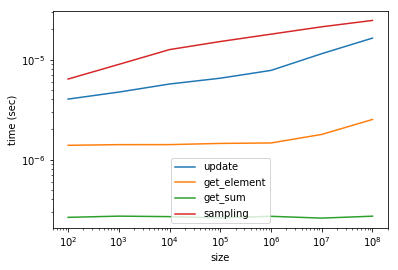

In [76]:
n_list_seg = [10**2,10**3,10**4,10**5,10**6,10**7,10**8]
update_time_seg = []
get_element_time_seg = []
get_sum_time_seg = []
sampling_time_seg = []
for n in n_list_seg:
    data_structure = SegmentTree(n)
    
    start_time = time.time()
    rep = 0
    while time.time()-start_time<0.1:
        index = np.random.randint(n)
        value = np.random.rand()
        data_structure.update(index,value)
        rep+=1
    elapsed = (time.time()-start_time)/rep
    update_time_seg.append(elapsed)
    
    start_time = time.time()
    rep = 0
    while time.time()-start_time<0.1:
        index = np.random.randint(n)
        data_structure.get_element(index)
        rep+=1
    elapsed = (time.time()-start_time)/rep
    get_element_time_seg.append(elapsed)
    
    start_time = time.time()
    rep = 0
    while time.time()-start_time<0.1:
        data_structure.get_sum()
        rep+=1
    elapsed = (time.time()-start_time)/rep
    get_sum_time_seg.append(elapsed)
    
    start_time = time.time()
    rep = 0
    while time.time()-start_time<0.1:
        data_structure.sampling()
        rep+=1
    elapsed = (time.time()-start_time)/rep
    sampling_time_seg.append(elapsed)
    
plt.plot(n_list_seg, update_time_seg,label="update")
plt.plot(n_list_seg, get_element_time_seg,label="get_element")
plt.plot(n_list_seg, get_sum_time_seg,label="get_sum")
plt.plot(n_list_seg, sampling_time_seg,label="sampling")
plt.xlabel("size")
plt.ylabel("time (sec)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

先ほどの素朴なデータ構造の時間と比較してみよう。

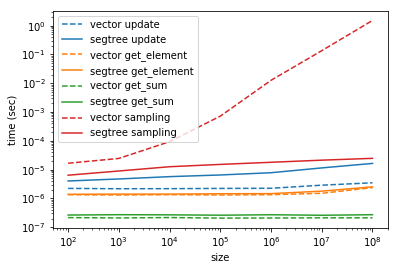

In [77]:
cmap = plt.get_cmap("tab10")
plt.plot(n_list_vec, update_time_vec,label="vector update",color=cmap(0),linestyle="--")
plt.plot(n_list_seg, update_time_seg,label="segtree update",color=cmap(0))
plt.plot(n_list_vec, get_element_time_vec,label="vector get_element",color=cmap(1),linestyle="--")
plt.plot(n_list_seg, get_element_time_seg,label="segtree get_element",color=cmap(1))
plt.plot(n_list_vec, get_sum_time_vec,label="vector get_sum",color=cmap(2),linestyle="--")
plt.plot(n_list_seg, get_sum_time_seg,label="segtree get_sum",color=cmap(2))
plt.plot(n_list_vec, sampling_time_vec,label="vector sampling",color=cmap(3),linestyle="--")
plt.plot(n_list_seg, sampling_time_seg,label="segtree sampling",color=cmap(3))
plt.xlabel("size")
plt.ylabel("time (sec)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

updateの関数はsegtreeの方が多少遅いものの、samplingのコストが圧倒的に減っていることがわかる。

なお、本稿では登場しないが、和のセグメント木は与えられた区間に関する和を求める操作も$O(\log n)$で行うことができる。これは通常のベクトルでは最悪で$O(n)$かかる。
また、セグメント木は二つの要素間の演算がモノイド、すなわちゼロ元を持ち結合則が成り立てば様々な対象に対し適用することができる。例えば$f(a,b)=\min(a,b)$とすることで区間最小値を求めるセグメント木を構築できる。

セグメント木はベクトルに対するデータ構造だが、多少の拡張をすることで行列をセグメント木の集合として表すことができる。下記のような$m \times n$行列を考えよう。

- $i$行目の長さ$n$のベクトル$T_i$をセグメント木$S_i$として保持する。
- $i$行目のベクトルの総和を$|T_i|$を並べた長さ$m$のベクトル$C = \{|T_i|\}$をセグメント木$S'$として保持する。

上記のようなデータ構造は、以下の操作を全て${\rm poly}(\log n, \log m)$で行う。

1. 値の更新: $(i,j)$要素を$v$に更新する。
2. 値の取得: $(i,j)$要素を取得する。
3. 行ノルムの取得: 与えられた行添え字$i$に対し、$i$行目のノルム$|T_i|$を取得する。
4. 行ベクトルのサンプリング: 与えられた行添え字$i$に対し、列添え字$j$を$\frac{T_{ij}}{\sum_j{ T_{ij}}}$の確率で得る。
5. 総和の取得: 行列の全要素の和$\sum_{ij} T_ij$を取得する。
6. 行ノルムのサンプリング: 行添え字$i$を$\frac{|T_i|}{\sum_i |T_i|}$の確率で得る。

実装は以下のようになる。

In [14]:
class SegmentTreeMatrix(object):
    def __init__(self, height, width):
        _height = 1
        while _height<height:
            _height*=2
        _width = 1
        while _width<width:
            _width*=2
        self.width = _width
        self.height = _height
        self.column_norm_segtree = SegmentTree(self.height)
        self.row_segtree_list = []
        for row_index in range(self.height):
            self.row_segtree_list.append(SegmentTree(self.width))
        
    def update(self,i,j, value):
        self.row_segtree_list[i].update(j,value)
        self.column_norm_segtree.update(i, self.row_segtree_list[i].get_sum())
        
    def get_element(self,i,j):
        return self.row_segtree_list[i].get_element(j)
    
    def get_row_norm(self,i):
        return self.row_segtree_list[i].get_sum()
                
    def sampling_column_in_row(self,i):
        return self.row_segtree_list[i].sampling()
    
    def get_sum(self):
        return self.column_norm_segtree.get_sum()
    
    def sampling_row(self):
        return self.column_norm_segtree.sampling()

## 確率的な打ち切り特異値分解

特異値分解とは正方とは限らない行列$A$について、$A=UDV^{\dagger}$という分解を行う$O(n^3)$の行列操作である。
この時、U,Vはユニタリ行列であり、$D$は実対角行列である。また、$\dagger$はエルミート共役(転置の複素共役)を表す。
$D$の対角要素を$A$の特異値と呼ぶ。行列$A$の幅と高さの小さいほうの値が$n$である場合、特異値は$n$個ある。$U$と$V$の$i$番目の列ベクトルを、$A$の$i$番目の特異値の左特異値ベクトル、右特異値ベクトルと呼ぶ。

特異値分解はnumpyに標準で搭載されている。

In [80]:
n = 3
m = 4
A = np.random.rand(n,m)
U,singular_value_list,Vd = np.linalg.svd(A)
D = np.zeros( (n,m) )
np.fill_diagonal(D,singular_value_list)
print("A=\n{}\n".format(A))
print("U=\n{}\n".format(U))
print("D=\n{}\n".format(D))
print("V^d=\n{}\n".format(Vd))
print("UDV^d=\n{}\n".format(U@D@Vd))

A=
[[0.80148124 0.456586   0.31251979 0.71004892]
 [0.35469256 0.6425928  0.81572885 0.35124637]
 [0.38492599 0.78442489 0.00978847 0.57766873]]

U=
[[-0.63318759  0.29599302  0.71516544]
 [-0.56837807 -0.80500243 -0.17005133]
 [-0.52537591  0.51415875 -0.67795349]]

D=
[[1.82207906 0.         0.         0.        ]
 [0.         0.62114842 0.         0.        ]
 [0.         0.         0.41435599 0.        ]]

V^d=
[[-0.50015299 -0.58529743 -0.3658835  -0.52287969]
 [ 0.24087246  0.03409237 -0.90015073  0.36131264]
 [ 0.60796472 -0.75911254  0.18860942  0.13621139]
 [-0.56763223 -0.28286531  0.14242334  0.75993188]]

UDV^d=
[[0.80148124 0.456586   0.31251979 0.71004892]
 [0.35469256 0.6425928  0.81572885 0.35124637]
 [0.38492599 0.78442489 0.00978847 0.57766873]]



計算コストは以下のようになる。

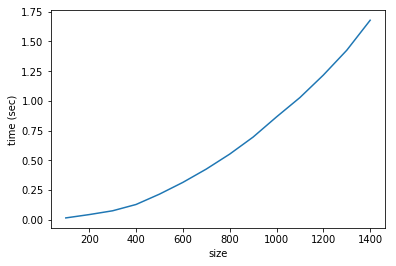

In [81]:
n_list = np.arange(100,1500,100)
elapsed_times_svd = []
for n in n_list:
    matrix = np.random.rand(n,n)
    start_time = time.time()
    s,d,v = np.linalg.svd(matrix)
    elapsed = time.time()-start_time
    elapsed_times_svd.append(elapsed)

plt.plot(n_list,elapsed_times_svd)
plt.xlabel("size")
plt.ylabel("time (sec)")
plt.show()

打ち切り特異値分解とは、定数$k$について、特異値の集合のうち大きいものから$k$個の特異値と特異値ベクトルを取り出す操作である。
定数$k=n$である場合は通常の特異値分解と一致するため、通常は$k$が$n$よりはるかに小さい場合をしばしば考える。

最も素朴な打ち切り特異値分解は、下記の$O(n^2 k)$のアルゴリズムである。

1. 各要素がN(0,1)の独立な正規分布に従う$n \times k$の行列$B$を作成する。計算コストは$O(nk)$。
2. $C = AB$を計算する。計算コストは$O(n^2 k)$。
3. $C$の行ベクトルを直行化し、行列$D$を得る。計算コストは$O(n^2 k)$
4. $E=DA$を計算する。計算コストは$O(n^2 k)$。
5. $E$を特異値分解し、$E=U'DV^{\dagger}$を得る。計算コストは$O(n^2 k)$。
6. $U = D^{\rm T}U'$を計算する。計算コストは$O(n^2 k)$。

結果として得られるU,D,Vは高い確率で$A$の特異値分解と一致する。
こうした特異値分解はscikit-learnに実装されている。

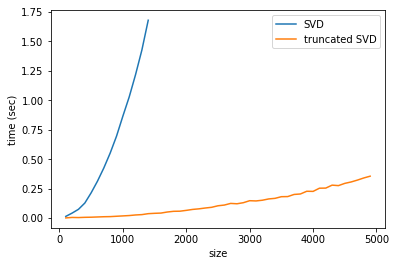

In [83]:
k = 10
n_list_tsvd = np.arange(100,5000,100)
elapsed_times_tsvd = []
for n in n_list_tsvd:
    matrix = np.random.rand(n,n)
    tsvd = TruncatedSVD(n_components=k)
    start_time = time.time()
    tsvd.fit(matrix)
    elapsed = time.time()-start_time
    elapsed_times_tsvd.append(elapsed)

plt.plot(n_list,elapsed_times_svd,label="SVD")
plt.plot(n_list_tsvd,elapsed_times_tsvd,label="truncated SVD")
plt.legend()
plt.xlabel("size")
plt.ylabel("time (sec)")
plt.show()

全ての特異値を得るFull SVDに比べ、圧倒的に高速であることがわかる。

FKVアルゴリズムはいくつかの条件が満たされると、Truncated SVDからさらなる高速化を可能にする。

1. 行列$A$から行ノルムを重みとして$p$個の行をサンプリングした$B$を作成する。行添え字$i$を行ノルムの重みづけで得るサンプリングのコストを$S_1(A)$として、計算コストは$O(S_1(A) p)$。
2. 行列$B$から「ランダムに行を選び、選ばれた行から要素を重みとして列をサンプリングする」操作をp回行い$C$を作成する。行ベクトルから要素のサンプリングコストを$S_2(A)$として、計算コストは$O(S_2(A)p)$。
3. $C$を特異値分解して$C=U'DV'^{\dagger}$を得る。計算コストは$O(p^3)$。
4. $V = B^T U' D^+$を計算する。計算コストは$O(np^2)$。
5. $V = V^{\dagger}D^+A$を計算する。計算コストは$O(n^2 p)$。

$p$を$\log n$の多項式としても、結果として得られる$U,D,V$は高い確率で$A$の特異値分解の良い近似となる。3.までえ得られる、積を取れば$U$が得られる(B,V',D)のセットのことをVの簡潔表現と呼ぶ。従って、Vの簡潔表現を得るための計算量は${\rm poly}(S_1(A), S_2(A), log n)$である。

行列の表現としてセグメント木行列を用いると、$S_1(A), S_2(A)$はどちらも$\rm poly(\log n)$である。従って、FKVアルゴリズムは行列がセグメント木の形式で保持されている場合は効率的に行うことができる。

FKVアルゴリズムの実装は以下のようになる。

In [36]:
def singular_value_decomposition_FKV(segtree_matrix, k, subsample_count):
    # row sampling
    ## sampled row index list
    row_index_list = []
    ## normalization factor for each sampled row index
    row_norm_list = []
    matrix_sum = segtree_matrix.get_sum()
    for _ in range(subsample_count):
        # choose row indices, where its weight is norm of row
        row_index = segtree_matrix.sampling_row()
        row_index_list.append(row_index)
        row_chosen_prob = segtree_matrix.get_row_norm(row_index) / matrix_sum
        row_norm_list.append(subsample_count * row_chosen_prob)

    # column sampling
    ## sampled column index list
    col_index_list = []
    ## normalization factor for each sampled column index
    col_norm_list = []
    ## uniformly choose row index from sampled index for sampling column
    col_sample_row = np.random.choice(row_index_list,size=subsample_count)
    for row_index in col_sample_row:
        # choose column indices, where its weight is element at chosen row/column.
        col_index = segtree_matrix.sampling_column_in_row(row_index)
        col_index_list.append(col_index)
        col_chosen_prob = 0.
        # compute sum of element in chosen column in row-sampled matrix
        for row_index_for_ave in row_index_list:
            col_chosen_prob += segtree_matrix.get_element(row_index_for_ave, col_index) / segtree_matrix.get_row_norm(row_index_for_ave)
        col_norm_list.append(col_chosen_prob)

    # pick normalized element from original matrix
    subsample_matrix = np.zeros( (subsample_count, subsample_count) )
    for sub_row in range(subsample_count):
        for sub_col in range(subsample_count):
            org_row = row_index_list[sub_row]
            org_col = col_index_list[sub_col]
            element = segtree_matrix.get_element(org_row, org_col)
            norm_factor = row_norm_list[sub_row] * col_norm_list[sub_col]
            subsample_matrix[sub_row,sub_col] = element / norm_factor

    # perform SVD for sampled matrix
    ## since segtree matrix contains squared values as elements, take sqrt for svd
    u,d,_ = np.linalg.svd(np.sqrt(subsample_matrix))
    
    # take top-k matrix
    d = d[:k]
    u = u[:,:k]
    return (row_index_list, d, u)

下のコードで示すように、量子状態のボルンの規則と合わせるため、量子状態の値はL2-normでサンプリングされる。セグメント木は和に対して定義されるため、総和がL2-normの二乗となるよう、セグメント木行列の要素には嗜好行列の要素の事情の値が格納される。従って、サブ行列を作成した後に特異値分解する際には、全要素のsqrtを取る必要がある。

このことを踏まえ、早速FKV algorithmを試してみよう。

In [48]:
n = m = 200
k = 10
p = 50
dense_matrix = np.zeros( (m,n) )
seg_tree = SegmentTreeMatrix(height = m, width = n)
for y in range(m):
    for x in range(n):
        val = np.random.rand()
        seg_tree.update(y,x,val**2)
        dense_matrix[y,x] = val

sampled_row_index_list, d, u = singular_value_decomposition_FKV(seg_tree, k, p)
print("FKV SVD\n",d)
_, d , _ = np.linalg.svd(dense_matrix)
print("Full SVD\n",d[:k])
tsvd = TruncatedSVD(n_components=k, n_iter=1)
tsvd.fit(dense_matrix)
print("Trunc SVD\n",tsvd.singular_values_)

FKV SVD
 [99.81614431 16.93979646 15.15136748 14.59428439 13.83162262 13.53672371
 13.04208667 12.54691985 12.33063108 11.87799307]
Full SVD
 [99.44748019  7.93662306  7.87989314  7.77416403  7.69304408  7.59591909
  7.4393028   7.34538147  7.30389676  7.20862063]
Trunc SVD
 [99.44747393  7.44671642  7.42707529  7.29234855  7.10630166  6.84797746
  6.73830552  6.62536363  6.57418709  6.50754707]


簡単な検証のため、$200 \times 200$の行列から$50 \times 50$のサブ行列を作成し、Top-10の特異値を表示している。最大特異値はおおむねあっているものの、以降の特異値でずれがひどいことが分かる。

次に$200 \times 200$の行列から$1000 \times 1000$のサブ行列(というのか分からないが)を作成し、Top-10の特異値を表示している。当たり前だが、この計算自体は元の行列より大きな行列をサンプリングしているため有用ではない操作である。

In [49]:
n = m = 200
k = 10
p = 1000
dense_matrix = np.zeros( (m,n) )
seg_tree = SegmentTreeMatrix(height = m, width = n)
for y in range(m):
    for x in range(n):
        val = np.random.rand()
        seg_tree.update(y,x,val**2)
        dense_matrix[y,x] = val

sampled_row_index_list, d, u = singular_value_decomposition_FKV(seg_tree, k, p)
print("FKV SVD\n",d)
_, d , _ = np.linalg.svd(dense_matrix)
print("Full SVD\n",d[:k])
tsvd = TruncatedSVD(n_components=k, n_iter=1)
tsvd.fit(dense_matrix)
print("Trunc SVD\n",tsvd.singular_values_)

FKV SVD
 [100.37783361   9.35966599   9.1647724    8.90074768   8.58897834
   8.46857633   8.32969532   8.2481131    8.17327124   8.01207616]
Full SVD
 [100.45202935   8.03256359   7.76069592   7.6734004    7.60053889
   7.56959946   7.46367527   7.37801194   7.34857857   7.21052356]
Trunc SVD
 [100.45201923   7.44910626   7.32481208   7.21809951   7.08035424
   6.9369945    6.86778243   6.8390597    6.73591323   6.63189109]


まだ十分とは言えないが、正しい値に漸近的に近づいていることが分かる。実は、FKVで必要となるサンプリング数$p$は$10^7 \times \max \left(\frac{k^{5.5}}{\epsilon^{17}}, \frac{k^4}{\epsilon^{24}} \right)$というとんでもない多項式になっている。従って、$k=10, \epsilon=0.1$に対して理論的な補償を得るためには、$p=10^{29.5}$というとんでもない数のサイズの行列が要請される。これが操作として意味を持つには$n,m > p$である必要があり、その行列のサイズは各要素が1bitだとしても$10^{59}$byteとなり、行ですら$10^{14}$PBという到底保持できないサイズとなる。もちろん、上記の多項式や係数は理論的な証明のためのオーバーヘッドを含むため、実際にはそれほど大きくしなくともそこそこの結果は得られると思われるが、いずれにせよ無条件に多項式だから有用だと言える手法ではないことは念頭に入れておきたい。

## 棄却サンプリング
一般に確率分布は高速にサンプリング可能とは限らない。
例えば$2^n$個の要素のうち$i$番目の要素が$p_i$の確率で得られる分布で、$i$に対して$p_i$が効率的に計算できるとしても、サンプリングには一般に指数的な時間を要する。

棄却サンプリングは上記のような効率的にサンプリングできるとは限らない分布$P$があるとき、
$P$と類似している効率的にサンプリング可能な分布$Q$を用いて$P$からのサンプリングを効率的に行う手法である。この時、最終的にサンプリングしたい分布$P$を目的分布、目的分布に近いと期待される効率的にサンプリング可能な分布$Q$を提案分布と呼ぶ。

具体的な手続きは以下である。

1. $M \geq \max_i \left( \frac{p_i}{q_i} \right)$となる$M$を求める。
2. $Q$からサンプリングを行い、$i$を得る。
3. $t = \frac{p_i}{Mq_i}$を計算する。
4. [0,1]の区間の一様乱数$r$を得る。$r<t$なら$i$を出力する。そうでなければ1.からやり直す。

上記の手続きで得られるサンプリング操作は$Q$からのサンプリング操作と一致する。
上記の操作に必要な計算量は$Q$からのサンプリングの操作が効率的なら$O(M)$の期待値で終了する。

効率の最良のケースは確率分布$P$と$Q$が一致している場合であり、$M=1$となる。ただしこの場合はそもそも棄却サンプリングを行う意味がない。最悪のケースは$p_i > 0$でかつ$q_i=0$となるような$i$が存在する場合である。この場合、$M = \infty$となり棄却サンプリングはそもそも実行できない。


例として、一様分布に十分近い$n$個のシンボルについての確率分布$\{p_i\}$を考えよう。この分布は全てのindexについて、おおよそ$p_i < 1.1 (1/n)$であることが保障されているとする。$\{p_i\}$からサンプリングするには最悪で$O(n)$が必要になるが、一様分布は$\log n$の速度で高速にサンプリングすることができる。

このことを利用して、$\{p_i\}$からのサンプリングを一様分布のサンプリングを用いて棄却サンプリングしてみよう。(以下の実装では規格化のために微妙に$M=1.1$からずれているが、おおむね$M=1.1$となる。)

In [84]:
def direct_sampling(prob_dist,index_list):
    index = np.random.choice(index_list, p = prob_dist)
    return index

def rejection_sampling(prob_dist, M, n):
    sampling_count = 0
    while True:
        index = np.random.randint(n)
        sampling_count+=1
        thr = prob_dist[index]/(M /n)
        r = np.random.rand()
        if r<thr:
            return index, sampling_count

まず、棄却サンプリングからサンプリングされる分布が、オリジナルの分布を再現しているかを検証してみよう。

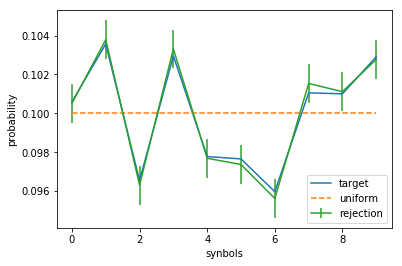

In [87]:
n = 10
prob_dist = (1./n) * (1.+ (np.random.rand(n)-0.5)*0.1)
prob_dist /= np.sum(prob_dist)
M = np.max(prob_dist / (1./n))
index_list = np.arange(n)
sample_count = 10**6

sample_rejection = []
for _ in range(sample_count):
    sample, _ =rejection_sampling(prob_dist, M, n)
    sample_rejection.append(sample)
counter = Counter(sample_rejection)

rejection_probs = []
for i in index_list:
    rejection_probs.append(counter[i]/sample_count)
plt.plot(index_list, prob_dist, label="target")
plt.plot(index_list, [1/n]*n, label="uniform",linestyle = "--")
plt.errorbar(index_list, rejection_probs, yerr=1./np.sqrt(sample_count), label="rejection")
plt.legend()
plt.xlabel("synbols")
plt.ylabel("probability")
plt.show()


確かに棄却サンプリングから得られる分布と目的分布が一致していることがわかる。次に、通常のサンプリングとの速度比較のベンチマークを取ってみよう。

M=1.0488414038894966
average repetition in rejection sampling = 1.0486176659682687


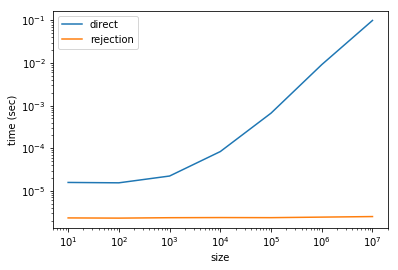

In [93]:
n_list = [10,10**2,10**3,10**4,10**5,10**6,10**7]
direct_sampling_time = []
rejection_sampling_time = []
sampling_count_list = []
M_list = []

for n in n_list:
    prob_dist = (1./n) * (1.+ (np.random.rand(n)-0.5)*0.1)
    prob_dist /= np.sum(prob_dist)
    M = np.max(prob_dist / (1./n))
    index_list = np.arange(n)

    start_time = time.time()
    rep = 0
    while time.time()-start_time < 0.1:
        index = direct_sampling(prob_dist,index_list)
        rep+=1
    elapsed_direct = (time.time()-start_time)/rep

    start_time = time.time()
    rep = 0
    sampling_count_average = 0
    while time.time()-start_time < 0.1:
        index, sampling_count = rejection_sampling(prob_dist, M, n)
        sampling_count_average += sampling_count
        rep+=1
    elapsed_rejection = (time.time()-start_time)/rep
    sampling_count_average /= rep

    direct_sampling_time.append(elapsed_direct)
    rejection_sampling_time.append(elapsed_rejection)
    M_list.append(M)
    sampling_count_list.append(sampling_count_average)
    
plt.plot(n_list, direct_sampling_time,label="direct")
plt.plot(n_list, rejection_sampling_time,label="rejection")
plt.legend()
plt.xlabel("size")
plt.ylabel("time (sec)")
plt.xscale("log")
plt.yscale("log")

print("M={}".format(np.mean(M_list)))
print("average repetition in rejection sampling = {}".format(np.mean(sampling_count_list)))

丁度よいサンプラーを持っている場合、直接的なサンプリングに比べ、棄却サンプリングは圧倒的に高速であることがわかる。また、$M$の値とサンプリング回数がおおむね一致している。

棄却サンプリングを行うにあたって注意しなければならない点が二つある。

一つ目は、棄却サンプリングを用いる代わりに、目的分布の確率ベクトルを高速なサンプリングは累積和やセグメント木などのデータ構造を用いることでも高速にサンプリングが可能になるという代替手段が存在する点である。例えばセグメント木を与えられたベクトルで初期化する手続きには$O(n)$が必要となる。サンプリングの回数を$s$とした場合、データ構造を用いて以降のサンプリングを効率化した場合の計算量は$O(n + s \log n)$であり、棄却サンプリングを行った場合は$O(M s \log n)$である。従って、棄却サンプリングを行う利点がある場合は
$$
\frac{n}{\log n} > (M-1) s
$$
の場合である。従って、$n$に対して$M$や$s$が非常に大きいような場合は最初にデータ構造を作ってしまうべきである。一方、小さい$M$が保障されておりサンプリングの回数が大きくない場合は棄却サンプリングは有効である。

二つ目は$M$の計算コストである。上記では$M$の計算コストは無視した。しかしながら、一般に二つの分布が与えられたとき、その間の$M$がどの程度に収まるかを計算するのは$O(n)$の時間が必要となる。もし$n$の時間をかけて$M$を計算したとすると、棄却サンプリングのコストは$O(n + Ms\log n)$となり常にセグメント木を用いるアプローチより低速である。従って、棄却サンプリングを有効に用いるには、目的分布の既知の性質から近いと確信が持てる提案分布が構成できなければならない。

## 内積の推定

二つの長さ$n$のベクトル$x,y$があるとき、この二つの内積$x\cdot y$を求める計算は$O(n)$を要する。一方、$x,y$についていくつか追加の操作が許されているとき、ある誤差の範囲内でより高速に内積の値を推定することができる。

サンプリング可能でノルムが既知のベクトル$x$と、一般のベクトル$y$がある場合、確率$p_i = \frac{x_i^2}{\left|x\right|^2}$の確率で変数$z_i = \frac{y_i}{x_i}|x|^2$を考える。この時、$z_i$の期待値は$E[z_i] = \sum_i p_i z_i = \sum_i x_i y_i = x \cdot y$となる。この時、$z_i$の分散は$V[z_i]^2 \leq |x|^2|y|^2$となる。

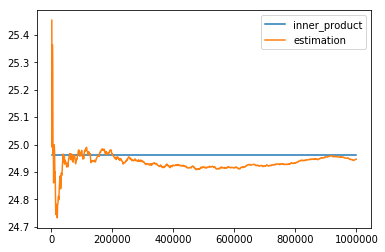

In [123]:
n = 100
x = np.random.rand(n)
x_square = x**2
x_square_norm = np.sum(x_square)
x_square_normalized = x_square / x_square_norm
y = np.random.rand(n)
inner_product = np.dot(x,y)
index_list = np.arange(n)

avg = 0
sampling_count_list = np.arange(0,1000000,1000)[1:]
estimation_list = []
for sample_index in range(max(sampling_count_list)):
    index = np.random.choice(index_list, p = x_square_normalized)
    z = y[index]/x[index] * x_square_norm
    avg += z
    if sample_index+1 in sampling_count_list:
        estimation_list.append(avg/(sample_index+1))
plt.plot([min(sampling_count_list), max(sampling_count_list)], [inner_product, inner_product], label = "inner_product")
plt.plot(sampling_count_list, estimation_list,label = "estimation")
plt.legend()
plt.show()

このように平均と分散が与えられたとき、median-of-meansと呼ばれるテクニックでサンプル数に対し信頼度の下で誤差を保証できる。
具体的には、$\frac{9}{2\epsilon^2}$個のサンプルについての平均値$\langle x\cdot y \rangle_s$を計算する。この操作を$6 \log \delta^{-1}$回行い、その中央値を取り出す。
このとき、得られた中央値が正しい値の$\epsilon |x||y|$以内にいる確率は$1-\delta$以上であることが保証できる。

従って、$1-\delta$以上の信頼度で$\epsilon|x||y|$以下の誤差で$x \cdot y$を得るために必要なサンプリングは$O(\epsilon^{-1} \log \delta^{-1})$である。

# ここまでのまとめ

ここまでで紹介した要素をいったんまとめよう。

## セグメント木行列

セグメント木行列は$m \times n$の実数行列$T$に対し、以下の操作を全て高々$O(\log nm)$の時間で実現する。

- $i$行$j$列要素$T_{ij}$の読み出し
- $i$行$j$列要素$T_{ij}$の更新
- $i$行目のL1ノルム$|T_i|$の計算
- $i$行目に対し、列添え字$j$を$\frac{T_{ij}}{|T_i|}$の確率で得るサンプリング
- 行列要素の総和$|T|:=\sum_i |T_i|$の計算
- 行添え字$i$を$\frac{|T_i|}{\sum_i |T|}$の確率で得るサンプリング

なお、行列$S$に対してL2-normに対するサンプリングを行いたい場合は、$T_{ij} = S_{ij}^2$としておけば、上記のノルムはL2-normの二乗に、要素総和はフロベニウスノルムの二乗に、サンプリングは二乗重みでのサンプリングになる。

## FKVアルゴリズム
ある$n \times k$の行列$V$が、$p = {\rm poly}(k)$を満たす整数$p$について、$n \times p$のセグメント木行列$A$と$p \times k$の密行列$B$の積で$V = AB$と表されるとき、$(A,B)$を$V$の簡潔表現と呼ぶ。

FKVアルゴリズムは、$m \times n$のセグメント木行列$T$と整数$k$と小さい実数$\epsilon$に対し、$T$のTop-$k$右特異値行列$V_k$を
$$
|T - T^{\rm FKV}|^2_{\rm F} \leq |T - T^{\rm SVD}|^2_{\rm F} + \epsilon |T|^2_{\rm F}
$$
と近似する行列$T^{\rm FKV}$の簡潔表現$(A,B)$を$k,\epsilon^{-1}$に対して多項式時間で与える。ただし、$T^{\rm SVD}$はSVDを用いて得られる$T$に対する最良のrank-$k$近似である。

## 棄却サンプリング

$n$個のシンボルに対する目的分布$\{p_i\}$と提案分布$\{q_i\}$を考える。これらの分布は以下を満たすとする。

- 与えられた$i$に対して$p_i$と$q_i$が$O(\log n)$で計算可能
- 添え字$i$を$q_i$の確率で得るサンプリングが$O(\log n)$で可能
- 任意の$i$について$M \geq \frac{p_i}{q_i}$を満たす整数$M$を計算可能

この時、添え字$i$を$p_i$の確率で得るサンプリングが$O(M \log n)$で可能になる。

## 内積の推定
長さ$n$のベクトル$x,y$について、以下が満たされるとする。

- 与えられた添え字$i$について、$x_i,y_i$が効率的に計算できる。
- ノルム$|x|$を効率的に計算できる。
- 添え字$i$を$\frac{x_i}{|x|}$の確率で得るサンプリングを効率的に行える。

この時、$x\cdot y$の値を$1-\delta$以上の確率で$\epsilon |x||y|$以内の誤差で求める計算を${\rm poly}(\epsilon^{-1},\log \delta^{-1})$で行うことができる。

# 低ランク行列を用いた高速な推薦

上記までのテクニックが分かっていれば、後は上記を組み合わせるだけである。Ewin Tangによる論文の殆どは、上記を組み合わせた時に要請される条件が満たされることの証明と、誤差や計算量の解析である。
誤差の評価を行うと記事が非常に長くなるため、ここでは行列であればフロベニウスノルムの差が、確率分布であればtotal variational distanceの差が$\epsilon$の比率のエラーで抑えられ、かつ計算時間は${\rm poly}(\epsilon)$に抑えられるという結果だけ述べておく。

Ewin Tangの論文は現地点(2019年3月)で３本からなるが、この記事では最初の二つを紹介する。といっても、二本目の論文の結果は一本目の論文の中間結果として得られるものなので、実質一本目の紹介である。

## 低ランク行列の主成分分析

Ewin Tangのアルゴリズムは全体のアルゴリズムの前半部分として$i$行ベクトルの主成分分析を行う。まずは、主成分分析とは以下のような手続きである。

行列$A$に対して特異値分解$A = U_k D_k V_k^{\dagger}$が得られたとき、$A$の$i$行目ベクトルのTop-$k$特異値空間へ次元を減らしたベクトル$v = A_i V_k$の要素を$A_i$のTop-$k$主成分と呼ぶ。この$k$主成分を$\epsilon$以内の誤差で求める操作を${\rm poly}(\log nm, \epsilon^{-1}, \log \delta^{-1} )$で行いたい。

行列$A$はセグメント行列を用いた行列に格納することで、FKVアルゴリズムを実施できる。FKVアルゴリズムを実施すると、$V=A_p^{\rm T}UD^+$となる簡潔表現$(A_p^{\rm T},UD^+)$を効率的に得ることができる($U,D^+$はそれぞれ与えられる)。この時、$A_p$は$p$個の行が$A$からサンプリングされたセグメント木行列表現を持つ。簡潔表現の$U,D^+$について、Top-k個の特異値と特異値ベクトルのみを取り出した行列をそれぞれ$U_k, D_k^+$として、我々がやるべきことは主成分ベクトル
$$
v = A_i V_k =A_i A_p^{\rm T} U_k D_k^+
$$
を計算することである。主成分の要素数は$k$個なので、$j$番目の主成分
$$
v_j = A_i \cdot (A_p^{\rm T} V_k D_k^+)_j
$$
を求める操作を$k$回繰り返せばよい。このとき、$A_i$はセグメント木であり、$(A_p^{\rm T} V_k D_k^+)_{kj}$は${\rm poly}(k)$で計算可能である。従って、内積の推定を行う条件を満たしている。$V_k$の列ベクトルはユニタリ行列の列を近似したものであるから、ノルムは$O(1)$である。したがって、$v_i$の誤差は$\epsilon |A_i|$である。

## 低ランク行列の特異値空間への射影

嗜好行列$A$の右特異値行列のTop-$k$特異値に相当する行を取り出したものを$V_k$とする。嗜好行列のある行$A_i$をTop-$k$特異値空間へ射影するとは、
$$
A_i' = A_i V_k V_k^{\dagger}
$$
という計算を行うことと等しい。我々の目的は与えられた添え字$i$について、上記のように求まる$A_i'$から、成分のL2-normの重みでサンプリングを行うことである。一つ前の節で$A_i V_k$は得られているため、我々がやるべきことは
$$
A_i' = v V_k^{\dagger} = v D_k^{+} U_k ^{\dagger} A_p
$$
からサンプリングすることである。これを棄却サンプリングを用いて行う。
記号を簡略化するため、$B :=D_k^{+} U_k ^{\dagger}$、$w = (A_i')^{\rm T}$と定義すると、以下のようになる。
$$
w = A_p^{\rm T} B v^{\rm T}
$$

まず、$A_p^{\rm T} B$の任意の列ベクトルはサンプリング可能であることを示す。$A_p^{\rm T}B$の$j$行目は$B$の$j$列目を$B^{(j)}$として、$A_p^{\rm T} B^{(j)}$である。従って、目的分布は
$$
p_i = \frac{|(A_p^{\rm T})_i B^{(j)}|^2}{|A_p^{\rm T} B^{(j)}|^2}
$$
である。これに対し、
$$
q_i = \sum_{l=1}^p \frac{|(A_p)_l|^2 (B^{(j)}_l)^2}{\sum_{m=1}^p |(A_p)_m|^2 (B^{(j)}_m)^2} \frac{|(A_p)_{jl}|^2}{|(A_p)_l|^2}
$$
という提案分布を考えると、これは効率的にサンプリング可能であり、かつコーシーシュワルツの不等式と$V'$の列は$V'$が等長行列であることから列ノルムが1であることを用いると、$M$が$k$の多項式で抑えられることが示せる。従って、$A_p^{\rm T} B$の任意の列ベクトルはサンプリング可能である。

最後に$A_p^{\rm T}B v^{\rm T}$は効率的にサンプリング可能であることを示す。$C=A_p^{\rm T}B$と置くと前節と同じ形式で
$$
q_i = \sum_{l=1}^p \frac{|C^{(l)}|^2 v_l^2}{\sum_{m=1}^p |C^{(m)}|^2 v_m^2} \frac{|C_{il}|^2}{|C^{(l)}|^2}
$$
を提案分布として用いる。この提案分布の積の左はセグメント木の性質を用いてサンプリング可能であり、右は直前の棄却サンプリングで可能である。ただし、左部は特定の$i$について計算することが難しいため、近似的に以下の値を用いる。
$$
\tilde{q}(i) = \sum_{l=1}^k \frac{|v_l|^2}{|v|^2} \frac{C_{il}^2}{|C^{(l)}|^2}
$$
これにより、最終的に得られる分布に$\epsilon$のtotal variational distanceの誤差は乗るものの、効率的に棄却サンプリングが可能となる。